In [2]:
import typing as t
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
from torchvision.transforms import ToTensor
import numpy as np
from sklearn.metrics import accuracy_score
from gridmix import GridMixupLoss

### Helpers for calculate accuracy and show images

In [3]:
def accuracy(preds: torch.Tensor, trues: torch.Tensor) -> float:
    lam = trues[-1, :][0].data.cpu().numpy()
    true_label = [trues[0, :].long(), trues[1, :].long()]
    trues = true_label[0] if lam > 0.5 else true_label[1]
    trues = trues.data.cpu().numpy().astype(np.uint8)
    preds = torch.softmax(preds, dim=1).float()
    preds = np.argmax(preds.data.cpu().numpy(), axis=1).astype(np.uint8)
    metric = accuracy_score(trues, preds)
    return float(metric)

In [4]:
def visualize_batch(images: np.ndarray, labels: np.ndarray):
    plt.figure(figsize=(10, 6))
    for ind, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(2, 2, ind + 1)
        plt.imshow(image)    
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

### Init simple dataset and dataloader

In [5]:
class SampleDataset(Dataset):    
    classes = {
        0: [255, 0, 0],
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [0, 255, 255]
    }
    
    def __init__(self, num_samples: 1000):
        self.class_list = [np.random.randint(min(self.classes), max(self.classes)) for _ in range(num_samples)]    
        self.augs = ToTensor()

    def __getitem__(self, idx: int) -> t.Dict[str, np.array]:
        label = self.class_list[idx]
        image = np.ones(shape=(224, 224, 3), dtype=np.uint8) * self.classes[label]
        image_tensor = self.augs(image)
        sample = {            
            'image': image_tensor,
            'target': label
        }
        return sample

    def __len__(self) -> int:
        return len(self.class_list)

train_dataset = SampleDataset(num_samples=1000)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    num_workers=1,
    shuffle=False
)

### Show the first batch of dataset

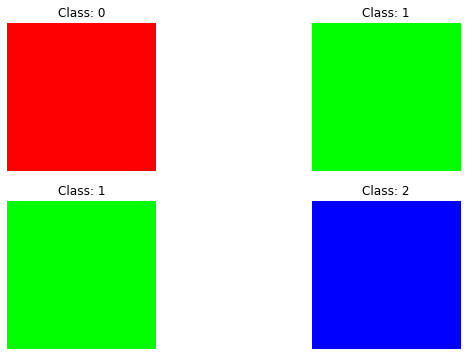

In [6]:
for batch in train_dataloader:
    images = np.moveaxis(batch['image'].data.cpu().numpy(), 1, -1)
    labels = batch['target']    
    visualize_batch(images, labels)
    break

### Define model

In [7]:
class SimpleModel(nn.Module):
    def __init__(self, out_classes: int = 4):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.relu2 = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, out_classes)
    
    def forward(self, x):        
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
model = SimpleModel().to("cuda")

### Define optimizer and criterion - GridMixupLoss

In [8]:
optimizer = SGD(params=model.parameters(), lr=0.0001)
criterion = GridMixupLoss(
    alpha=(0.4, 0.7),
    hole_aspect_ratio=1.,
    crop_area_ratio=(0.5, 1),
    crop_aspect_ratio=(0.5, 2),
    n_holes_x=(2, 6)
)

### Simple train loop

In [9]:
epochs_total = 5
model.train()
for epoch in range(epochs_total):
    info = ""
    info += f"Epoch: {epoch + 1}/{epochs_total}"
    # Init metric lists
    losses = []
    metrics = []
    
    # Iter over dataset
    for n_iter, data in enumerate(train_dataloader):
        # Get images and targets
        images = data['image'].float().to("cuda")
        labels = data['target'].unsqueeze(-1).to("cuda")        
        
        # Apply GridMix
        inputs, targets = criterion.get_sample(images=images, targets=labels)  
        
        # Predict
        preds = model(inputs)            
        
        # Calculate accuracy
        acc = accuracy(preds, targets)
        metrics.append(acc)
        
        # Calculate loss
        loss = criterion(preds, targets)   
        losses.append(loss.item())
                
        # Steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print info
    info += f"'loss': {np.mean(losses)}, 'metric': {np.mean(metrics)}"
    print(info)

Epoch: 1/5'loss': 1.0814795371134729, 'metric': 0.916
Epoch: 2/5'loss': 0.626438344131071, 'metric': 0.932
Epoch: 3/5'loss': 0.4583437018331606, 'metric': 0.966
Epoch: 4/5'loss': 0.40648755827825517, 'metric': 0.978
Epoch: 5/5'loss': 0.39161032465472817, 'metric': 0.978
